## Prelimiary Operations

### Useful operations

In [1]:
import os
import shutil
if os.path.exists("/kaggle/working/andrea"):
    shutil.rmtree("/kaggle/working/andrea")

In [2]:
if os.path.exists("/kaggle/working/EfficientNet_experiments"):
    shutil.rmtree("/kaggle/working/EfficientNet_experiments")

In [3]:
if os.path.exists("/kaggle/working/EfficientNet"):
    shutil.rmtree("/kaggle/working/EfficientNet")

In [4]:
# to remove a file
import os
if os.path.exists("/kaggle/working/model.png"):
    os.remove("/kaggle/working/model.png")

In [5]:
# to create a folder
import os
directory = "EfficientNet"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
if not os.path.exists(path):
    os.mkdir(path)

### Operations

In [6]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [7]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [8]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importing data

In [9]:
labels = ['Species1',   # 0
          'Species2',   # 1
          'Species3',   # 2
          'Species4',   # 3
          'Species5',   # 4
          'Species6',   # 5
          'Species7',   # 6
          'Species8']   # 7

In [10]:
# Dataset folders 
dataset_dir = "../input/splitted-dataset-no-test/splitted_dataset_no_test"
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [11]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator, and for the trainign with Data Augmentation


train_data_gen = ImageDataGenerator(rotation_range=15,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        zoom_range=0.1,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='reflect')



#train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 3432 images belonging to 8 classes.
Found 864 images belonging to 8 classes.


In [13]:
#batch = get_next_batch(train_gen)

## Model

In [14]:
!cd /kaggle/working/EfficieNet

/bin/bash: line 0: cd: /kaggle/working/EfficieNet: No such file or directory


In [16]:
# Download and plot the EfficientNet model
eff_net = tfk.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3),
)

eff_net.trainable = False # we are freezing the weights of the conv part, so that they are not updated
                            # during the training
#tfk.utils.plot_model(eff_net)

16719872/16705208 [==============================] - 0s 0us/step


In [17]:
input_shape = (96, 96, 3)
epochs = 500
learning_rate = 1e-2
l1=0
l2=0

In [18]:
# Som elayers might be commented for the different trials we made.

def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    #x = tfkl.Resizing(64, 64, interpolation="bicubic", name='resizing')(input_layer)
    efficient_net = eff_net(input_layer)
    
    #x = tfkl.Flatten()(efficient_net)
    x = tfkl.GlobalAveragePooling2D()(efficient_net)
    #x = tfkl.Dropout(0.2, seed=seed)(x)
    x = tfkl.Dense(units=512, name='classifier1', 
                   kernel_initializer=tfk.initializers.HeUniform(seed),
                   activation='relu',
                   kernel_regularizer=tfk.regularizers.L1L2(l1=l1, l2=l2))(x)
    #x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.3, seed=seed)(x)
    output_layer = tfkl.Dense(
        8, 
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
        # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='efficient_net_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')

    # Return the model
    return model

Model: "efficient_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 3, 3, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
classifier1 (Dense)          (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
Total params: 4,709,547
Trainable params: 659,976
Non-trainable params: 4,049,571
_______________________________

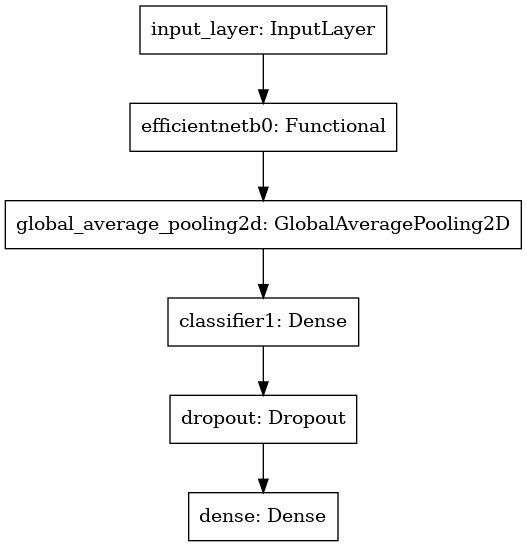

In [19]:
# Build model
eff_net_model = build_model(input_shape)
eff_net_model.summary()
tfk.utils.plot_model(eff_net_model)

In [20]:
# Phase 1: make layers from 6d trainable
eff_net_model.get_layer('efficientnetb0').trainable = False

eff_net.trainable = True
set_trainable = False

for layer in eff_net.layers:
    if layer.name == 'block6d_se_excite':
        set_trainable = True
    if set_trainable:
        if not isinstance(layer, tfkl.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    else:
        layer.trainable = False
        
eff_net_model.summary()

Model: "efficient_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 3, 3, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
classifier1 (Dense)          (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
Total params: 4,709,547
Trainable params: 2,002,744
Non-trainable params: 2,706,803
_____________________________

## Training

In [21]:
patience = 20

In [22]:
model_name = "Efficient_net_fine_tuning"

In [23]:
# Phase 1 train
eff_net_model_history = eff_net_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 100,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)],
).history

Epoch 1/100
429/429 [==============================] - 38s 61ms/step - loss: 1.8653 - accuracy: 0.3951 - val_loss: 1.6206 - val_accuracy: 0.4711
Epoch 2/100
429/429 [==============================] - 17s 39ms/step - loss: 1.6463 - accuracy: 0.4248 - val_loss: 1.4329 - val_accuracy: 0.5046
Epoch 3/100
429/429 [==============================] - 17s 39ms/step - loss: 1.7031 - accuracy: 0.4205 - val_loss: 1.3862 - val_accuracy: 0.5220
Epoch 4/100
429/429 [==============================] - 16s 38ms/step - loss: 1.6022 - accuracy: 0.4400 - val_loss: 1.4181 - val_accuracy: 0.4757
Epoch 5/100
429/429 [==============================] - 17s 39ms/step - loss: 1.6154 - accuracy: 0.4467 - val_loss: 1.3593 - val_accuracy: 0.5289
Epoch 6/100
429/429 [==============================] - 16s 38ms/step - loss: 1.5989 - accuracy: 0.4554 - val_loss: 1.2038 - val_accuracy: 0.5752
Epoch 7/100
429/429 [==============================] - 17s 40ms/step - loss: 1.4859 - accuracy: 0.4575 - val_loss: 1.3727 - val_ac

In [24]:
# Phase 2: make layers from 5a trainable
eff_net.trainable = True
set_trainable = False

for layer in eff_net.layers:
    if layer.name == 'block5a_se_excite':
        set_trainable = True
    if set_trainable:
        if not isinstance(layer, tfkl.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    else:
        layer.trainable = False
        
eff_net_model.summary()

Model: "efficient_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 3, 3, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
classifier1 (Dense)          (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
Total params: 4,709,547
Trainable params: 4,254,940
Non-trainable params: 454,607
_______________________________

In [25]:
# Reduce learning rate for phase 2
learning_rate = 1e-4
eff_net.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')

In [26]:
# Phase 2 train
eff_net_model_history = eff_net_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 500,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)],
).history

Epoch 1/500
429/429 [==============================] - 18s 42ms/step - loss: 1.3735 - accuracy: 0.5530 - val_loss: 1.1176 - val_accuracy: 0.6528
Epoch 2/500
429/429 [==============================] - 19s 44ms/step - loss: 1.2366 - accuracy: 0.5522 - val_loss: 1.0401 - val_accuracy: 0.6574
Epoch 3/500
429/429 [==============================] - 18s 42ms/step - loss: 1.2854 - accuracy: 0.5571 - val_loss: 1.2730 - val_accuracy: 0.6887
Epoch 4/500
429/429 [==============================] - 18s 43ms/step - loss: 1.3655 - accuracy: 0.5591 - val_loss: 1.2688 - val_accuracy: 0.6562
Epoch 5/500
429/429 [==============================] - 18s 42ms/step - loss: 1.2755 - accuracy: 0.5772 - val_loss: 1.4000 - val_accuracy: 0.6574
Epoch 6/500
429/429 [==============================] - 19s 43ms/step - loss: 1.2601 - accuracy: 0.5717 - val_loss: 1.4018 - val_accuracy: 0.6701
Epoch 7/500
429/429 [==============================] - 20s 46ms/step - loss: 1.2915 - accuracy: 0.5685 - val_loss: 1.2052 - val_ac

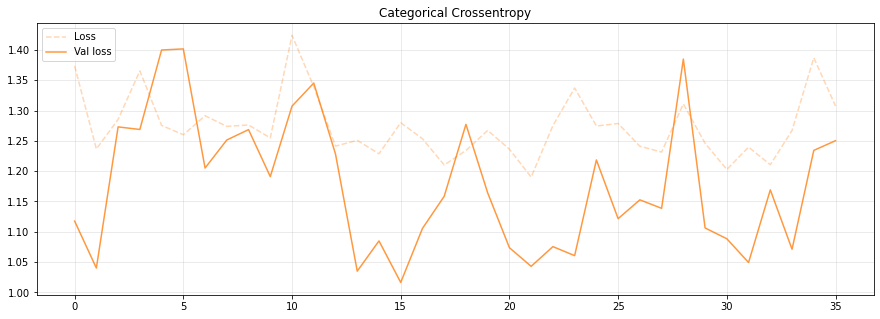

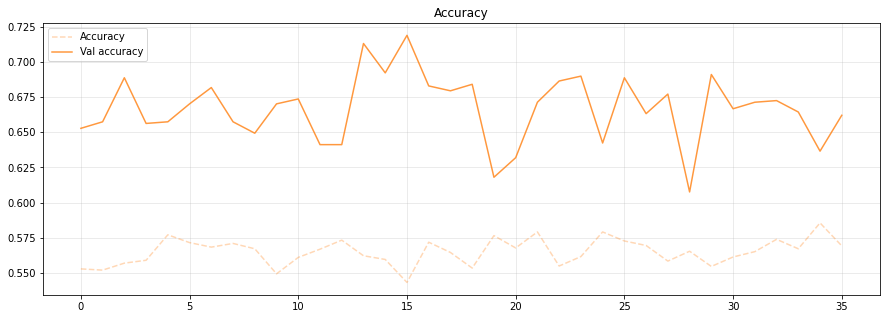

In [27]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(eff_net_model_history['loss'], label='Loss', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(eff_net_model_history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig(model_name + "cat_cr_en.png")

plt.figure(figsize=(15,5))
plt.plot(eff_net_model_history['accuracy'], label='Accuracy', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(eff_net_model_history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig(model_name + "acc.png")

plt.show()

In [28]:
# Save the best model
eff_net_model.save(model_name)

In [29]:
# Evaluate on val
val_metrics = eff_net_model.evaluate(valid_gen, return_dict=True)

print()
print("Val metrics")
print(val_metrics)

108/108 [==============================] - 2s 17ms/step - loss: 1.0163 - accuracy: 0.7188

Val metrics
{'loss': 1.0163216590881348, 'accuracy': 0.71875}


In [30]:
import shutil
shutil.make_archive(model_name, 'zip', "/kaggle/working/EfficientNet")

'/kaggle/working/Efficient_net_fine_tuning.zip'